In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.optimize import curve_fit

This is how beta and nrand catalogs where created:

In [2]:
RawVoidCats = []

nrand_steps = 5
beta_steps  = 5

beta  = np.linspace(1.2, 2.0, beta_steps)
nrand = np.linspace(1.0, 1.8, nrand_steps)

CounterZero = 60


for i in range(CounterZero,80):
    dataset = np.loadtxt("volume_and_excentricity/{}.vae".format(i), delimiter=",")
    j = i % nrand_steps
    k = (i-CounterZero)//nrand_steps 
    
    RawVoidCats.append([i, beta[j], np.round(nrand[k], decimals=1), dataset])   
    
nrand_steps = 4

beta = 1.0
nrand = np.linspace(1.0, 1.6, nrand_steps)
CounterZero = 50

for i in range(CounterZero, 54):
    dataset = np.loadtxt("volume_and_excentricity/{}.vae".format(i), delimiter=",")
    k = (i - CounterZero) % nrand_steps
    RawVoidCats.append([i, beta, np.round(nrand[k], decimals=1), dataset])
    
nrand_steps = 4
nrand = 1.8
beta  = np.linspace(1.0, 1.6, nrand_steps)
beta  = np.round(beta, decimals=1)
CounterZero = 30

for i in range(30, 34):
    dataset = np.loadtxt("volume_and_excentricity/{}.vae".format(i), delimiter=",")
    k = (i - CounterZero) % nrand_steps
    RawVoidCats.append([i, beta[k], nrand, dataset])
    
i = 36 
dataset = np.loadtxt("volume_and_excentricity/{}.vae".format(i), delimiter=",")
beta  = 1.0
nrand = 2.0
RawVoidCats.append([i, beta, nrand, dataset])


In [3]:
BoxLength = 720
Trim = 30

def TrimCatalog(ellip_cat):    
    halfboxtrim = BoxLength/2 - Trim

    index = np.where( 
            (abs(ellip_cat[:,1]) < halfboxtrim)   & 
            (abs(ellip_cat[:,2]) < halfboxtrim)   & 
            (abs(ellip_cat[:,3]) < halfboxtrim) )
    
    return ellip_cat[index]

def ellipticity(a,b,c):
    return (1/4.)*((a**2 - c**2) / (a**2 + b**2 + c**2))

def prolatness(a,b,c):
    return(1/4.)*( (b**2-c**2)+(b**2 - a**2)) / (a**2 + b**2 + c**2)


## To do the prolate/oblate scatter plot.
def density_estimation(m1, m2, xmin, xmax, ymin, ymax):
    X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]                                                     
    positions = np.vstack([X.ravel(), Y.ravel()])                                                       
    values = np.vstack([m1, m2])                                                                        
    kernel = scipy.stats.gaussian_kde(values)                                                                 
    Z = np.reshape(kernel(positions).T, X.shape)
    return X, Y, Z

Volume = (BoxLength - 2*Trim) ** 3
print(Volume)

287496000


In [4]:
VoidCats = []

for i in range(len(RawVoidCats)):
    j     = RawVoidCats[i][0]
    beta  = RawVoidCats[i][1]
    nrand = RawVoidCats[i][2]
    #print(j, beta, nrand, len(RawVoidCats[i][-1]))
    VoidCats.append([beta, nrand, TrimCatalog(RawVoidCats[i][-1])])



nan_array = np.zeros((1,1))
    
VoidCats.append([1.2, 2.0, nan_array])
VoidCats.append([1.4, 2.0, nan_array])
VoidCats.append([1.6, 2.0, nan_array])
VoidCats.append([1.8, 1.8, nan_array])
VoidCats.append([1.8, 2.0, nan_array])
VoidCats.append([2.0, 1.8, nan_array])
VoidCats.append([2.0, 2.0, nan_array])

In [5]:
# Sort by nrand
VoidCats.sort(key = lambda x: x[1])
# Sort by beta
VoidCats.sort(key = lambda x: x[0])

In [6]:
ncats = len(VoidCats)

# Prolatness vs Ellipticity

In [7]:
def plot_prolatness_vs_ellipticity(fig, position, Dataset, xlabel=True, ylabel=True):
    ax = fig.add_subplot(position)

    unity = np.array([0,0.25])

    beta    = Dataset[0]
    nrand   = Dataset[1]
    VoidCat = Dataset[-1]

    xmin, xmax, ymin, ymax =  0, 0.25, -0.25, 0.25
    
    label = r"$\beta={{{:2.1f}}}$".format(beta)
    label += "\n"
    label += r"$n_{\mathrm{rnd} } = $" 
    label += "{:2.1f}".format(nrand)

    
    if ( VoidCat.shape != (1,1)):

        a = VoidCat[:,6]
        b = VoidCat[:,7]
        c = VoidCat[:,8]

        e = ellipticity(a,b,c)
        p = prolatness(a,b,c)

        print("beta={:2.1f}, nrand={:2.1f}. \tellipticity, prolatness".format(beta, nrand))
        print(np.percentile(e, [25, 50, 75]), np.percentile(p, [25, 50, 75]))
        


        ### Kernel Density begins here.
        X, Y, Z = density_estimation(e, p, xmin, xmax, ymin, ymax)
        ax.imshow(np.rot90(Z), 
                     cmap=plt.cm.terrain_r, 
                     extent=[xmin, xmax, ymin, ymax], 
                     aspect=1)   #aspect='auto'
        #plt.colorbar()
        # Add contour lines
        ax.contour(X, Y, Z, cmap="terrain")       
        ### Kernel Density ends here.

        #ax.text(0.04, 0.17, label)
        ax.scatter(e,p, s=0.1, label=label)

    else:
        ax.scatter(0,0, s=0.1, label=label)
           
    ax.plot(unity,  unity, linestyle="-.", color="k", lw=1)
    ax.plot(unity, -unity, linestyle="-.", color="k", lw=1)
    ax.axhline(0, color="k", lw=1)
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    if(xlabel): 
        ax.set_xlabel("Ellipticity", fontsize=15)
        
    
    if(ylabel): 
        ax.set_ylabel("Prolatness", fontsize=15)
    else:
        ax.set_yticks([-0.2, -0.1, 0.0, 0.1, 0.2])
        ax.set_yticklabels([])
    
    ax.tick_params(axis="x",   top=True, direction="in")
    ax.tick_params(axis="y", right=True, direction="in")
    
    ax.set_xticks([0,0.1,0.2])
    ax.set_xticklabels(["0.0", "0.1", "0.2"])

In [8]:
def plot_prolatness_vs_ellipticity_R_cut(ax, Dataset, R_cut):
    
    unity = np.array([0,0.25])

    beta    = Dataset[0]
    nrand   = Dataset[1]
    VoidCat = Dataset[-1]

    xmin, xmax, ymin, ymax =  0, 0.25, -0.25, 0.25
    
    if (VoidCat.shape != (1,1)):

        R = VoidCat[:,5]
        
        index = np.where(R > R_cut)
        
        a = VoidCat[index,6]
        b = VoidCat[index,7]
        c = VoidCat[index,8]

        e = ellipticity(a,b,c)
        p = prolatness(a,b,c)

        
        e_p = np.percentile(e, [25, 50, 75])
        p_p = np.percentile(p, [25, 50, 75])
        
        e_m     = e_p[1]
        e_minus = e_p[0] - e_p[1]
        e_plus  = e_p[2] - e_p[1]
        p_m     = p_p[1]
        p_minus = p_p[0] - p_p[1]
        p_plus  = p_p[2] - p_p[1]
        
        print("beta={:2.1f}, nrand={:2.1f}. \tellipticity, prolatness".format(beta, nrand))
        print("{:1.4f} {:1.4f} {:1.4f}\t {:1.4f} {:1.4f} {:1.4f}".format(e_m, e_minus, e_plus, p_m, p_minus, p_plus))

        ### Kernel Density begins here.
        X, Y, Z = density_estimation(e, p, xmin, xmax, ymin, ymax)
        ax.imshow(np.rot90(Z), 
                     cmap=plt.cm.terrain_r, 
                     extent=[xmin, xmax, ymin, ymax], 
                     aspect='auto')   #aspect='auto','1'
        #plt.colorbar()
        # Add contour lines
        ax.contour(X, Y, Z, cmap="terrain")       
        ### Kernel Density ends here.
    
    ax.plot(unity,  unity, linestyle="-.", color="k", lw=1)
    ax.plot(unity, -unity, linestyle="-.", color="k", lw=1)
    ax.axhline(0, color="k", lw=1)
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    ax.tick_params(axis="x",   top=True, direction="in")
    ax.tick_params(axis="y", right=True, direction="in")
    
    ax.set_xticks([0,0.1,0.2])
    ax.set_xticklabels(["0.0", "0.1", "0.2"])
    ax.grid(True, which="both", axis="both")

    

beta=1.0, nrand=1.0. 	ellipticity, prolatness
0.1034 -0.0172 0.0215	 -0.0568 -0.0251 0.0401
beta=1.0, nrand=1.2. 	ellipticity, prolatness
0.1101 -0.0279 0.0263	 -0.0590 -0.0368 0.0386
beta=1.0, nrand=1.4. 	ellipticity, prolatness
0.1120 -0.0249 0.0228	 -0.0513 -0.0451 0.0355
beta=1.0, nrand=1.6. 	ellipticity, prolatness
0.1130 -0.0244 0.0236	 -0.0592 -0.0356 0.0387
beta=1.0, nrand=1.8. 	ellipticity, prolatness
0.1188 -0.0245 0.0190	 -0.0620 -0.0326 0.0383
beta=1.0, nrand=2.0. 	ellipticity, prolatness
0.1195 -0.0229 0.0202	 -0.0680 -0.0253 0.0416
beta=1.2, nrand=1.0. 	ellipticity, prolatness
0.1153 -0.0267 0.0163	 -0.0616 -0.0338 0.0449
beta=1.2, nrand=1.2. 	ellipticity, prolatness
0.1115 -0.0187 0.0245	 -0.0562 -0.0337 0.0437
beta=1.2, nrand=1.4. 	ellipticity, prolatness
0.1161 -0.0230 0.0278	 -0.0576 -0.0453 0.0300
beta=1.2, nrand=1.6. 	ellipticity, prolatness
0.1160 -0.0200 0.0245	 -0.0580 -0.0343 0.0385
beta=1.2, nrand=1.8. 	ellipticity, prolatness
0.1187 -0.0205 0.0249	 -0.0605 -0.

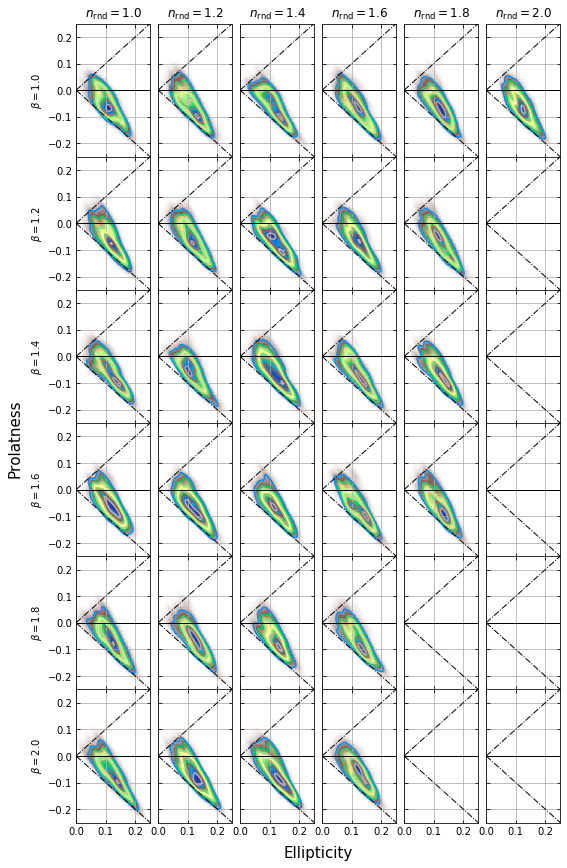

In [9]:
beta_steps  = 6
nrand_steps = 6
ylabelPE = "Prolatness"
xlabelPE = "Ellipticity"

fig, ax = plt.subplots(nrows=beta_steps, 
                       ncols=nrand_steps, 
                       sharex=True, 
                       sharey=True,
                       figsize=(8,12))
k = 0
for i in range(beta_steps):
    for j in range(nrand_steps):
        beta  = VoidCats[k][0]
        nrand = VoidCats[k][1] 
        plot_prolatness_vs_ellipticity_R_cut(ax[i][j], VoidCats[k], 30)

        if(j==0):
            ax[i][j].set_ylabel(r"$\beta =$" + str(beta))
        if(i==0):
            ax[i][j].set_title(r"$n_{\mathrm{rnd} } =$" + str(nrand))     
        k +=1

fig.text(0.50, 0.02, xlabelPE, va='center', fontsize=15)        
fig.text(0.02, 0.50, ylabelPE, va='center', rotation='vertical', fontsize=15)        

plt.tight_layout(pad=0, rect=(0.06, 0.04, 0.98, 1.0))
plt.savefig("figures/prolatness_vs_ellipticity_beta_nrand_variations_big_voids.pdf")

# Fraction of Volume in Voids vs Box Volume 

In [10]:
# Sort by beta, then by nrand.
VoidCats.sort(key = lambda x: x[0])
VoidCats.sort(key = lambda x: x[1])

linestyles = ['solid', 'dashed', 'dashdot', 'dotted', 'solid', 'dashed', 'dashdot', 'dotted']
linecolour = ['k', 'k', 'k', 'k', 'gray', 'gray', 'gray', 'gray']

1.0 1.0 0.275 0.049
1.2 1.0 0.347 0.087
1.4 1.0 0.394 0.107
1.6 1.0 0.413 0.127
1.8 1.0 0.425 0.145
2.0 1.0 0.42 0.147
1.0 1.2 0.378 0.107
1.2 1.2 0.476 0.187
1.4 1.2 0.533 0.229
1.6 1.2 0.563 0.255
1.8 1.2 0.581 0.293
2.0 1.2 0.573 0.285
1.0 1.4 0.486 0.196
1.2 1.4 0.633 0.33
1.4 1.4 0.704 0.397
1.6 1.4 0.784 0.492
1.8 1.4 0.79 0.508
2.0 1.4 0.768 0.488
1.0 1.6 0.62 0.326
1.2 1.6 0.791 0.491
1.4 1.6 1.027 0.753
1.6 1.6 1.03 0.766
1.8 1.6 1.033 0.777
2.0 1.6 1.053 0.804
1.0 1.8 0.842 0.559
1.2 1.8 1.132 0.854
1.4 1.8 1.447 1.196
1.6 1.8 1.582 1.34
1.0 2.0 1.133 0.87


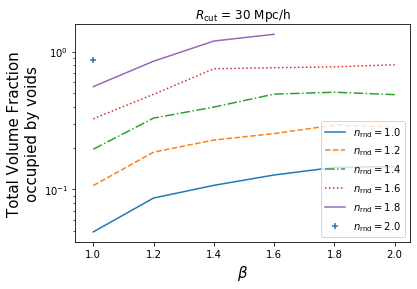

In [11]:
beta_steps  = 6
nrand_steps = 6

R_cut = 30 # Mpc/h

k = 0
for i in range(nrand_steps):
    beta_list = []
    vol_frac  = []
    vol_trim_frac = []
    
    for j in range(beta_steps):
        beta    = VoidCats[k][0]
        nrand   = VoidCats[k][1] 
        Dataset = VoidCats[k][2]
        k+=1
        
        
        if (Dataset.shape != (1,1)):
            R = Dataset[:,5]
            V = (4.0/3.0) * np.pi * R**3
            
            index = np.where(R> R_cut)
            Vtrim = (4.0/3.0) * np.pi *R[index]**3

            Vt = np.sum(V)     
            Vttrim = np.sum(Vtrim)

            
            beta_list.append(beta)
            vol_frac.append(Vt/ Volume)
            vol_trim_frac.append(Vttrim/ Volume)
            
            print( beta, nrand, 
                  np.round(Vt/Volume, decimals=3),
                  np.round(Vttrim/Volume, decimals=3))
    if( i!= 5):
        plt.plot(beta_list, vol_trim_frac, ls=linestyles[i],
                 label=r"$n_\mathrm{rnd}=$" + str(nrand))
    else:
        plt.scatter(beta_list, vol_trim_frac, marker="+",
                 label=r"$n_\mathrm{rnd}=$" + str(nrand))

plt.title(r"$R_\mathrm{cut}$ = 30 Mpc/h")
plt.ylabel("Total Volume Fraction\noccupied by voids", fontsize=15)        
plt.xlabel(r"$\beta$", fontsize=15)
plt.yscale("log")
plt.legend(loc=0)

In [12]:
!head -n 2 volume_and_excentricity/60.vae

# Void_ID, X_c, Y_c, Z_c, N_particles, R=(abc)^(-1/3), a, b, c, vector_a, vector_b, vector_c 



In [13]:
!wc -l observed_catalogs/v300.dat

271452 observed_catalogs/v300.dat


Halo density in the 720 Mpc/h box 0.0007272698045267489

Particle density in the void
beta nrand, part_density, part_density/halo_density
1.0 1.0 0.000643 0.884
1.2 1.0 0.000623 0.857
1.4 1.0 0.000623 0.857
1.6 1.0 0.000603 0.828
1.8 1.0 0.000593 0.815
2.0 1.0 0.000575 0.79
1.0 1.2 0.000615 0.846
1.2 1.2 0.000597 0.82
1.4 1.2 0.000573 0.787
1.6 1.2 0.000572 0.786
1.8 1.2 0.000547 0.752
2.0 1.2 0.000542 0.746
1.0 1.4 0.000585 0.804
1.2 1.4 0.000558 0.768
1.4 1.4 0.000542 0.746
1.6 1.4 0.000518 0.713
1.8 1.4 0.000517 0.71
2.0 1.4 0.000509 0.699
1.0 1.6 0.000559 0.768
1.2 1.6 0.000531 0.73
1.4 1.6 0.000507 0.698
1.6 1.6 0.000492 0.676
1.8 1.6 0.000483 0.664
2.0 1.6 0.00048 0.66
1.0 1.8 0.000519 0.714
1.2 1.8 0.000502 0.69
1.4 1.8 0.000481 0.662
1.6 1.8 0.000481 0.661
1.0 2.0 0.000495 0.681


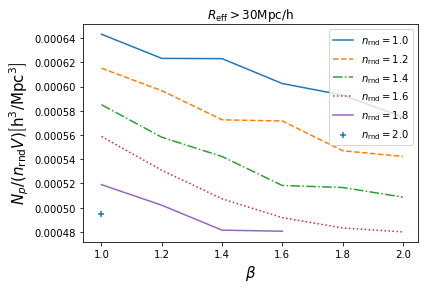

In [14]:
HalosInCatalog = 271452
HaloDensity = 271452.  / (720.**3)
print("Halo density in the 720 Mpc/h box" , HalosInCatalog * 720.0**(-3))

R_cut = 30 # Mpc/h

beta_steps  = 6
nrand_steps = 6

print("\nParticle density in the void")
print("beta nrand, part_density, part_density/halo_density")
k = 0
for i in range(nrand_steps):
    
    beta_list = []
    ratio_list = []
    
    for j in range(beta_steps):
        beta    = VoidCats[k][0]
        nrand   = VoidCats[k][1] 
        Dataset = VoidCats[k][2]
        k+=1
        
        
        if (Dataset.shape != (1,1)):
            R     = Dataset[:,5]                    
            index = np.where(R > R_cut)
            V     = (4.0/3.0) * np.pi * R[index]**3
            Np    = Dataset[index,4] 
            
            ratio = Np / (nrand * V)
            
            print(beta, nrand, np.round(ratio.mean(), decimals=6), 
                  np.round(ratio.mean()/HaloDensity, decimals=3) ) 

            beta_list.append(beta)
            ratio_list.append(ratio.mean())
    
    if( i!= 5):
        plt.plot(beta_list, ratio_list, ls=linestyles[i],
                 label=r"$n_\mathrm{rnd}=$" + str(nrand))
    else:
        plt.scatter(beta_list, ratio_list, marker="+",
                 label=r"$n_\mathrm{rnd}=$" + str(nrand))

#plt.axhline(y=HaloDensity, label="Halo Density")
        
ylabelUnits = r"$ \left[ \mathrm{h^3 / Mpc^3} \right]$"
plt.ylabel(r"$N_p / ( n_{ \mathrm{rnd} } V )$" + ylabelUnits, fontsize=15)
plt.xlabel(r"$\beta$", fontsize=15)
plt.title(r"$R_\mathrm{eff}>30$" + "Mpc/h")
plt.legend(loc=0)

### Checking  for $\beta=1.0$ and $n_{rnd}=1.0$

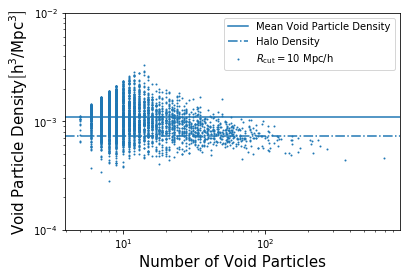

In [15]:
k = 0

beta    = VoidCats[k][0]
nrand   = VoidCats[k][1] 
Dataset = VoidCats[k][2]

R = Dataset[:,5]
Np = Dataset[:,4]
V = (4/3.) * np.pi * R**3
R_cut = 10

index = np.where(R> R_cut)
void_particle_density = Np[index] / (V[index] * nrand)

plt.scatter(Np[index], void_particle_density, s=1, label=r"$R_\mathrm{cut}=10$" + " Mpc/h")
plt.axhline(y = void_particle_density.mean(), label = "Mean Void Particle Density")
plt.axhline(y= 271452.0 * 720**(-3), ls="dashdot", label = "Halo Density")

plt.yscale("log")
plt.xscale("log")
plt.ylim(0.0001, 0.01)
plt.xlabel("Number of Void Particles", fontsize=15)
plt.ylabel("Void Particle Density" + ylabelUnits, fontsize=15)
plt.legend(loc=0)

/hpcfs/home/fl.gomez10/.conda/envs/pythesis/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


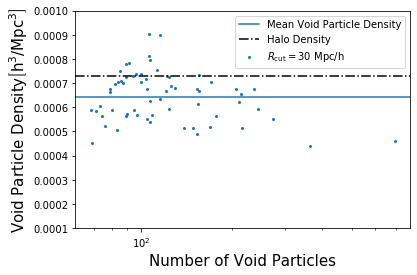

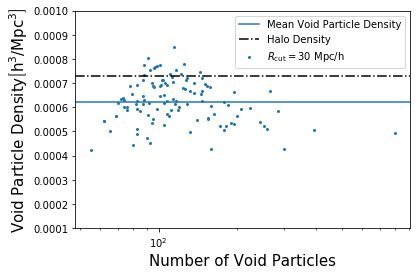

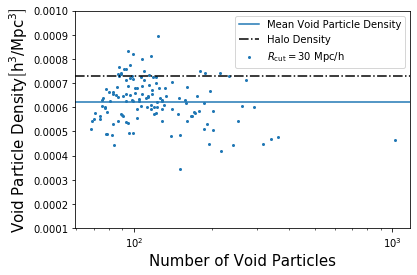

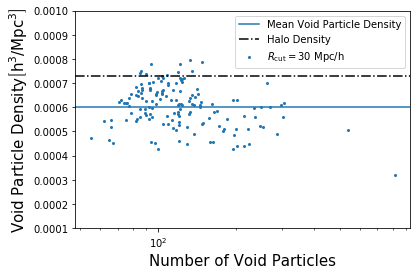

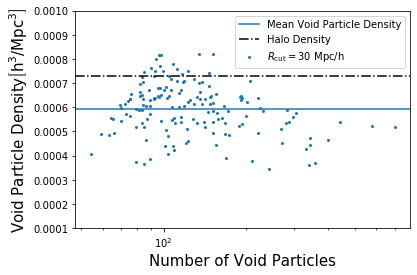

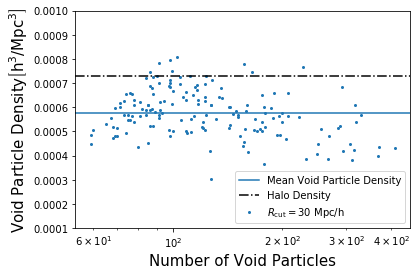

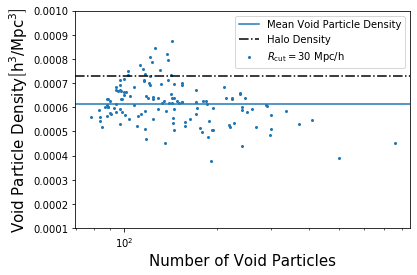

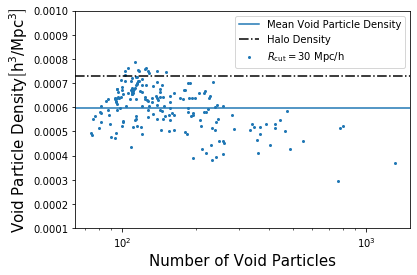

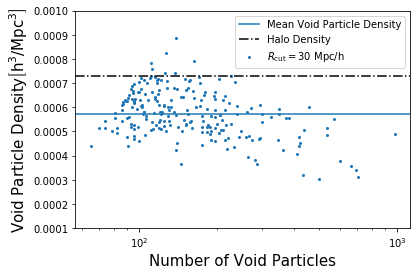

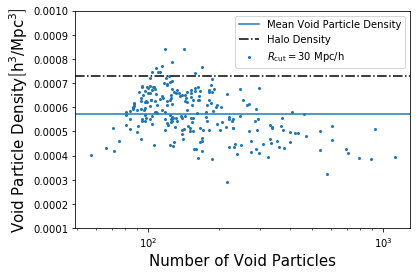

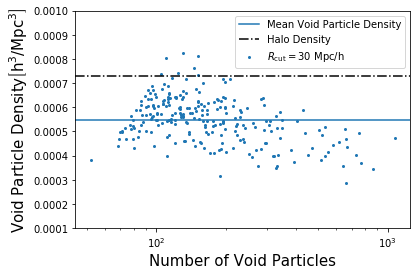

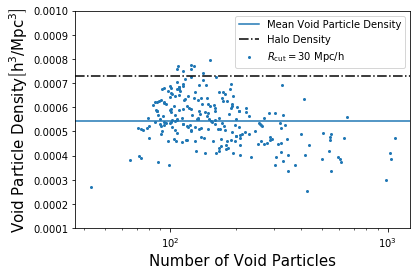

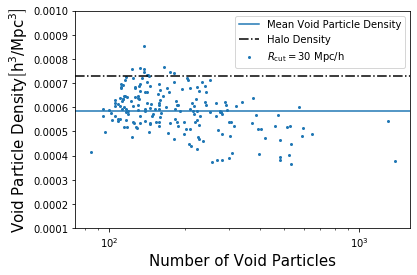

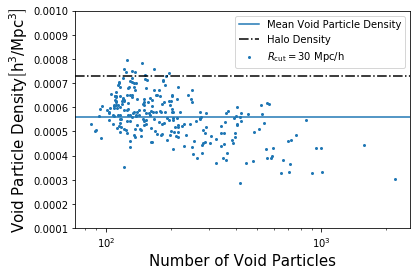

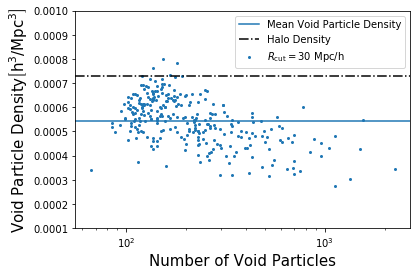

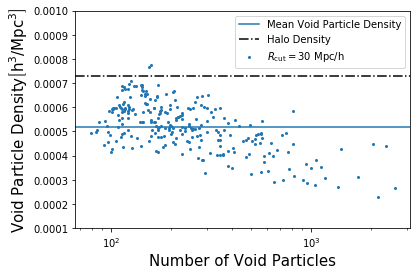

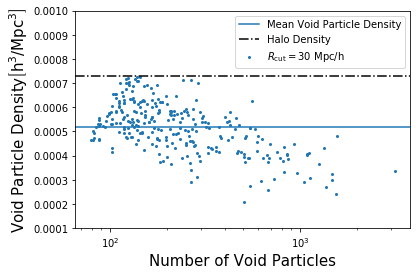

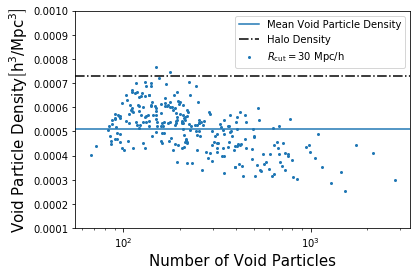

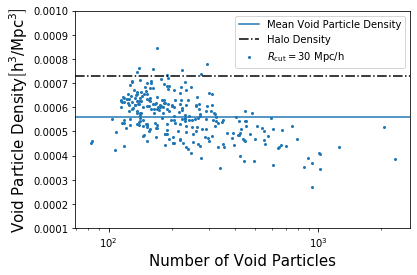

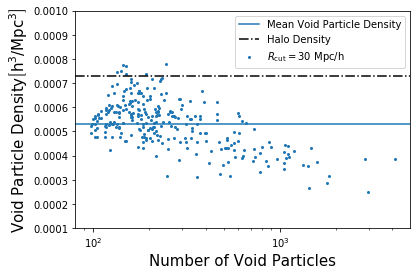

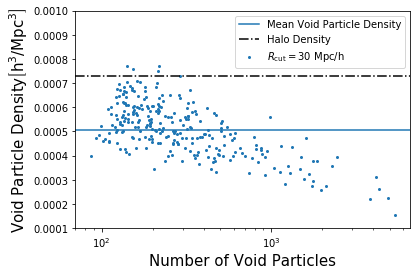

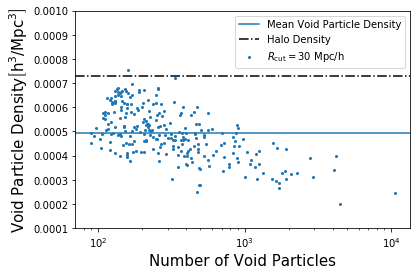

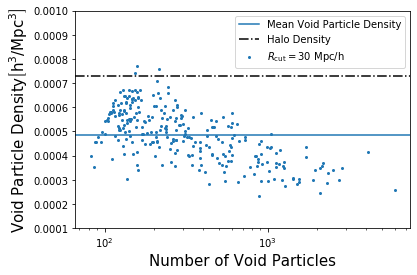

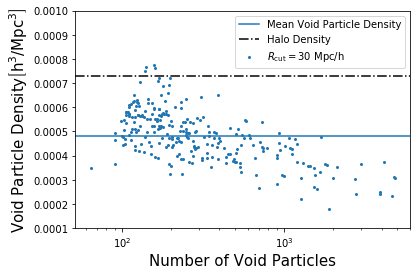

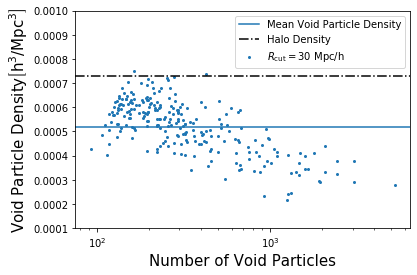

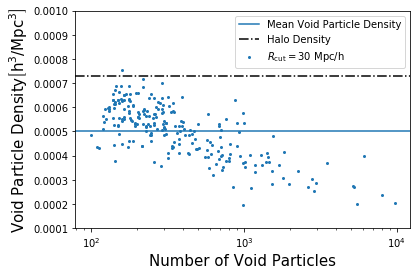

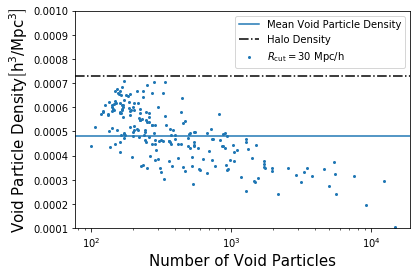

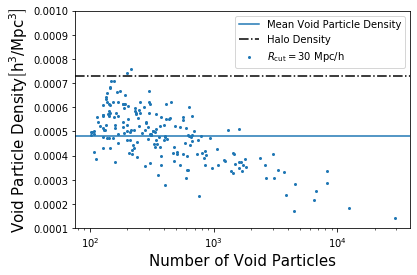

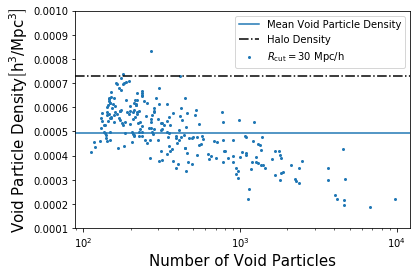

In [16]:
for k in range(ncats):

    beta    = VoidCats[k][0]
    nrand   = VoidCats[k][1] 
    Dataset = VoidCats[k][2]

    if (Dataset.shape != (1,1)):
        R = Dataset[:,5]
        Np = Dataset[:,4]
        V = (4/3.) * np.pi * R**3
        R_cut = 30

        index = np.where(R> R_cut)

        void_particle_density = Np[index] / (V[index] * nrand)

        plt.figure()
        plt.scatter(Np[index], void_particle_density, s=4, label=r"$R_\mathrm{cut}=$" + str(R_cut) + " Mpc/h")
        plt.axhline(y = void_particle_density.mean(), label = "Mean Void Particle Density")
        plt.axhline(y= 271452.0 * 720**(-3), c="k", ls="dashdot", label = "Halo Density")

        #plt.yscale("log")
        plt.xscale("log")
        plt.ylim(0.0001, 0.001)
        plt.xlabel("Number of Void Particles", fontsize=15)
        plt.ylabel("Void Particle Density" + ylabelUnits, fontsize=15)
        plt.legend(loc=0)

10
[0.00045993]


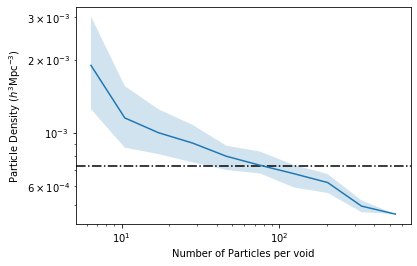

In [17]:
Nbins = 10
k = 0
beta    = VoidCats[k][0]
nrand   = VoidCats[k][1] 
Dataset = VoidCats[k][2]
if (Dataset.shape != (1,1)):
    R = Dataset[:,5]
    Np = Dataset[:,4]
    V = (4/3.) * np.pi * R**3
    logNp = np.log10(Np)
    hist, bins= np.histogram( logNp, bins=Nbins )
    bins_c = ( bins[1:] + bins[:-1] )/2.
    
    vdp_aux = []
    for l in range(Nbins):
        index2  = np.where((logNp >= bins[l]) & (logNp <= bins[l+1]))[0]
        vdp_aux.append( Np[index2] / (V[index2] * nrand))

    q1 = []
    q2 = []
    q3 = []
    
    print(len(vdp_aux))

    print(vdp_aux[-1])

    for l in range(Nbins):
        q1.append(np.percentile(vdp_aux[l], 25))
        q2.append(np.percentile(vdp_aux[l], 50))
        q3.append(np.percentile(vdp_aux[l], 75))
        
    plt.axhline(y= 271452.0 * 720**(-3), c="k", ls="dashdot", label = "Halo Density")
    plt.plot(10**bins_c, q2)    
    plt.fill_between(10**bins_c, q1, q3, alpha=0.2)
    
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Number of Particles per void")
    plt.ylabel(r"Particle Density ($h^3 \mathrm{Mpc}^{-3}$)")

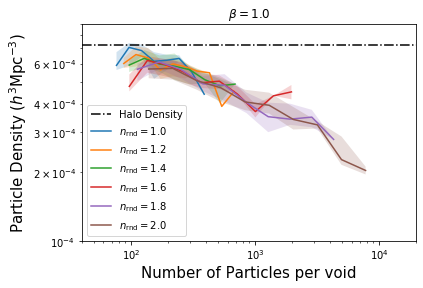

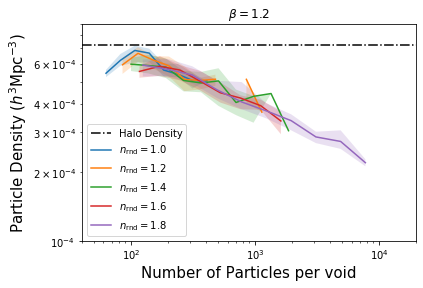

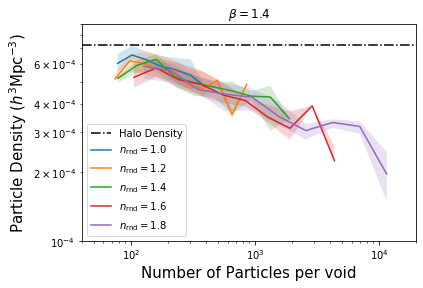

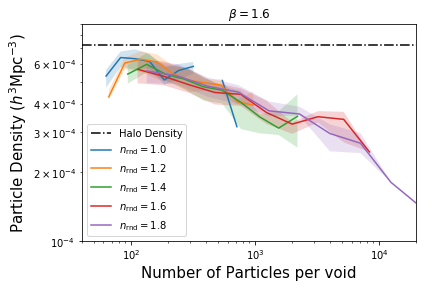

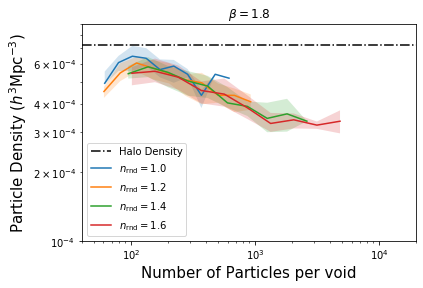

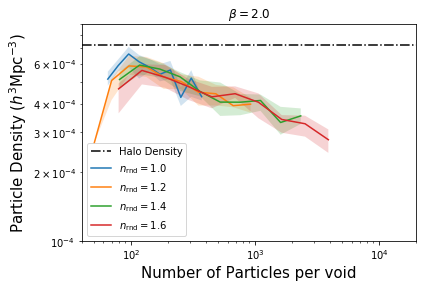

In [18]:
# Sort by nrand, then by beta
VoidCats.sort(key = lambda x: x[1])
VoidCats.sort(key = lambda x: x[0])

Nbins = 10
R_cut = 30



k = 0
for i in range(beta_steps):
    fig = plt.figure()
    plt.axhline(y= 271452.0 * 720**(-3), c="k", ls="dashdot", label = "Halo Density")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(40, 2e4)
    plt.ylim(1e-4, 9e-4)
    plt.xlabel("Number of Particles per void", fontsize=15)
    plt.ylabel(r"Particle Density ($h^3 \mathrm{Mpc}^{-3}$)", fontsize=15)

    
    for j in range(nrand_steps):

        beta    = VoidCats[k][0]
        nrand   = VoidCats[k][1] 
        Dataset = VoidCats[k][2]

        k+=1
        if (Dataset.shape != (1,1)):
            R = Dataset[:,5]
            
            index1 = np.where(R >= R_cut)[0]

            Np = Dataset[index1,4]
            V = (4/3.) * np.pi * R[index1]**3
            
            logNp = np.log10(Np)
            
            hist, bins= np.histogram( logNp, bins=Nbins )
            bins_c = ( bins[1:] + bins[:-1] )/2.

            vdp_aux = []
            for l in range(Nbins):
                index2  = np.where((logNp >= bins[l]) & (logNp <= bins[l+1]))[0]
                vdp_aux.append( Np[index2] / (V[index2] * nrand))

            q1 = []
            q2 = []
            q3 = []

            for l in range(Nbins):
                if(len(vdp_aux[l])==0): # Percentile throws error when  the array is empty
                    q1.append(np.nan)
                    q2.append(np.nan)
                    q3.append(np.nan)
                else:
                    q1.append(np.percentile(vdp_aux[l], 25))
                    q2.append(np.percentile(vdp_aux[l], 50))
                    q3.append(np.percentile(vdp_aux[l], 75))

            plt.plot(10**bins_c, q2, label=r"$n_\mathrm{rnd}=$"+str(nrand))    
            plt.fill_between(10**bins_c, q1, q3, alpha=0.2)
            

    plt.title(r"$\beta=$"+str(beta))

    plt.legend(loc="lower left")

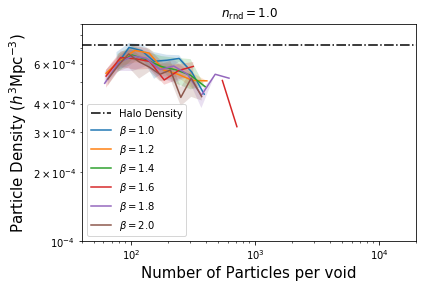

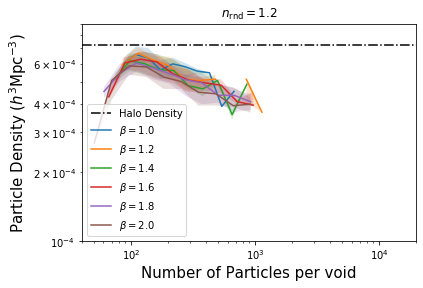

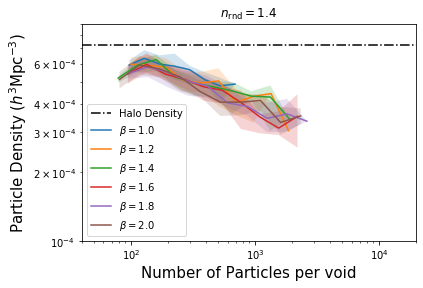

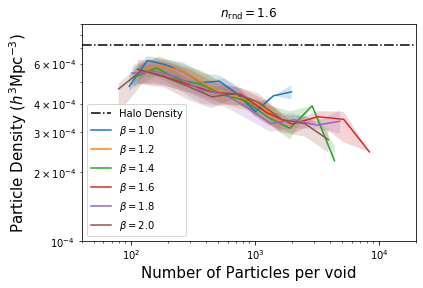

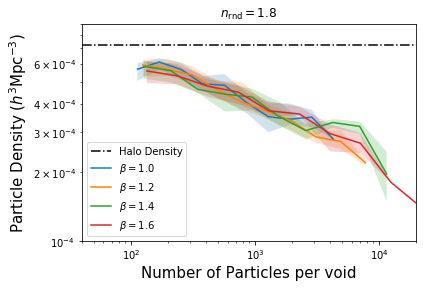

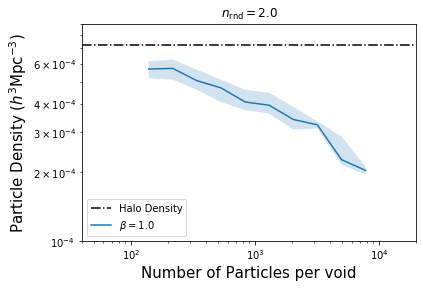

In [19]:
# Sort by nrand, then by beta
VoidCats.sort(key = lambda x: x[0])
VoidCats.sort(key = lambda x: x[1])

Nbins = 10
R_cut = 30



k = 0
for i in range(nrand_steps):
    fig = plt.figure()
    plt.axhline(y= 271452.0 * 720**(-3), c="k", ls="dashdot", label = "Halo Density")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(40, 2e4)
    plt.ylim(1e-4, 9e-4)
    plt.xlabel("Number of Particles per void", fontsize=15)
    plt.ylabel(r"Particle Density ($h^3 \mathrm{Mpc}^{-3}$)", fontsize=15)

    
    for j in range(beta_steps):

        beta    = VoidCats[k][0]
        nrand   = VoidCats[k][1] 
        Dataset = VoidCats[k][2]

        k+=1
        if (Dataset.shape != (1,1)):
            R = Dataset[:,5]
            
            index1 = np.where(R >= R_cut)[0]            
            Np = Dataset[index1,4]
            V = (4/3.) * np.pi * R[index1]**3
            
            logNp = np.log10(Np)
            
            hist, bins= np.histogram( logNp, bins=Nbins )
            bins_c = ( bins[1:] + bins[:-1] )/2.

            vdp_aux = []
            for l in range(Nbins):
                index2  = np.where((logNp >= bins[l]) & (logNp <= bins[l+1]))[0]
                vdp_aux.append( Np[index2] / (V[index2] * nrand))

            q1 = []
            q2 = []
            q3 = []

            for l in range(Nbins):
                if(len(vdp_aux[l])==0): # Percentile throws error when  the array is empty
                    q1.append(np.nan)
                    q2.append(np.nan)
                    q3.append(np.nan)
                else:
                    q1.append(np.percentile(vdp_aux[l], 25))
                    q2.append(np.percentile(vdp_aux[l], 50))
                    q3.append(np.percentile(vdp_aux[l], 75))

            plt.plot(10**bins_c, q2, label=r"$\beta=$"+str(beta))    
            plt.fill_between(10**bins_c, q1, q3, alpha=0.2)
            

    plt.title(r"$n_\mathrm{rnd}=$"+str(nrand))

    plt.legend(loc="lower left")